In [244]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,r2_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [245]:
df = pd.read_csv('Tweets_Corona_NLP.csv',encoding='ISO-8859-1')

In [246]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [247]:
df.shape

(41157, 6)

In [248]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [249]:
#checking missing values
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [250]:
#checking missing values percentage
df.isnull().sum()/len(df)*100

UserName          0.000000
ScreenName        0.000000
Location         20.871298
TweetAt           0.000000
OriginalTweet     0.000000
Sentiment         0.000000
dtype: float64

# Data Imbalance

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

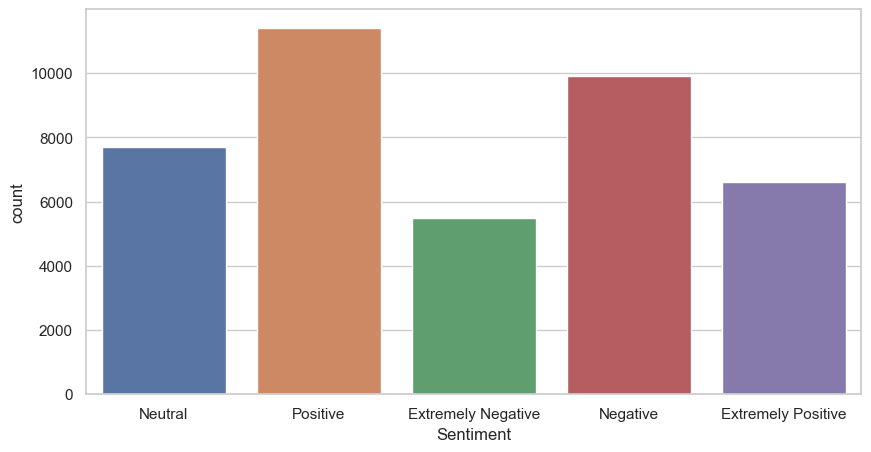

In [251]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=df)

# Interpretation:
* From the graph, we can observe that the data is imbalanced.

In [252]:
df['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [253]:
stop_words = set(stopwords.words('english'))

#### Remove punctuations, stopwords and any words of length 1 or 2 if needed.

This regex pattern is designed to identify:
* Mentions (e.g., @username)
* Hashtags (e.g., #hashtag)
* URLs (e.g., http://example.com)
* Special characters or punctuation
* Standalone short words (1 or 2 characters)

In [254]:
reg = re.compile(r"(@[A-Za-z0-9_]+)|(#\w+)|(http\S+)|[^\w\s]|\b\w{1,2}\b")

def clean_text(text):
    text = reg.sub(" ", text)
    tokens = text.lower().split()
    #Removing stop words
    filtered_words = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_words)

df['CleanedTweet'] = df['OriginalTweet'].apply(clean_text)

In [255]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak paranoid food stock...


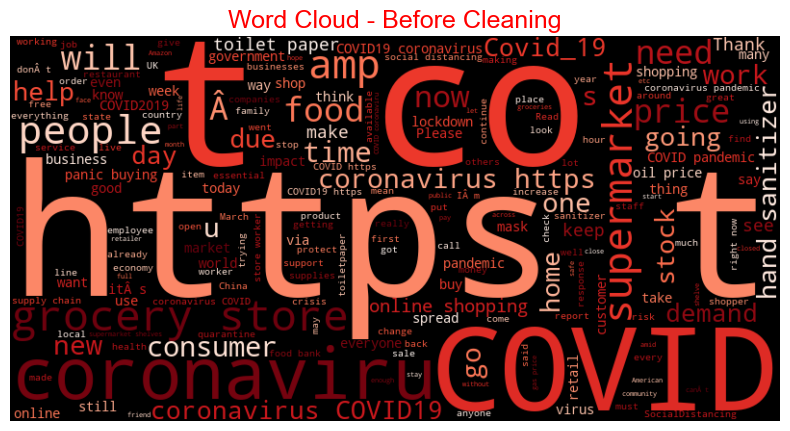

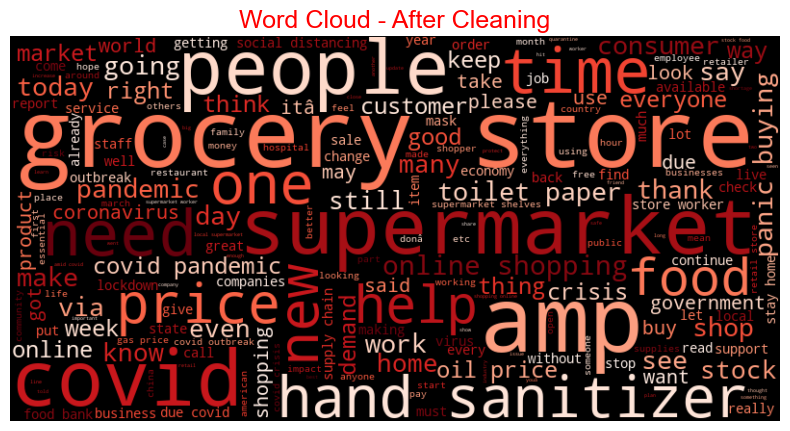

In [256]:
original_text = ' '.join(df['OriginalTweet'])
wordcloud_original = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(original_text)

cleaned_text = ' '.join(df['CleanedTweet'])
wordcloud_cleaned = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(cleaned_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_original, interpolation='bilinear')
plt.title('Word Cloud - Before Cleaning', fontsize=18, color='red')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.title('Word Cloud - After Cleaning', fontsize=18, color='red')
plt.axis('off')
plt.show()

In [257]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,ready supermarket outbreak paranoid food stock...


In [258]:
# Dropping unnecessary columns
df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt'], inplace=True)

#### Justification for Dropping Columns:

#### UserName and ScreenName:
Reason: These columns contain identifiers for the users who tweeted. In sentiment analysis, the actual content of the tweet (the text itself) is more important than who tweeted it. Therefore, these columns do not contribute to the sentiment classification and can be dropped.

#### Location:
* Reason: While the location might provide contextual information about the sentiment expressed, it is not directly related to the content of the tweet. Since this model focuses on text-based sentiment analysis, the location does not contribute meaningful information for this specific task and can be removed.

### TweetAt:
* Reason: The timestamp of when the tweet was made is not relevant to determining the sentiment of the tweet. The sentiment is based on the language and tone of the content, not when it was tweeted.

In [259]:
#cekecking missing values
df.isnull().sum()

OriginalTweet    0
Sentiment        0
CleanedTweet     0
dtype: int64

#### TF-IDF along with Random Forest Classifier

In [260]:
X = df['CleanedTweet']
y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

y_pred = rf_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.5529640427599611

Confusion Matrix:
 [[ 429   17  433   65  112]
 [  11  522   47   62  688]
 [ 174   47  998  346  441]
 [  12   14  154 1207  166]
 [  38  163  355  335 1396]]

Classification Report:
                     precision    recall  f1-score   support

Extremely Negative       0.65      0.41      0.50      1056
Extremely Positive       0.68      0.39      0.50      1330
          Negative       0.50      0.50      0.50      2006
           Neutral       0.60      0.78      0.68      1553
          Positive       0.50      0.61      0.55      2287

          accuracy                           0.55      8232
         macro avg       0.59      0.54      0.54      8232
      weighted avg       0.57      0.55      0.55      8232



### Extremely Negative
* Precision: 0.65 (65% of predicted "Extremely Negative" tweets are correct)
* Recall: 0.41 (Only 41% of actual "Extremely Negative" tweets are identified)

### Extremely Positive
* Precision: 0.68 (68% accuracy for predicted "Extremely Positive" tweets)
* Recall: 0.39 (39% of actual "Extremely Positive" tweets are captured)

####Negative
* Precision: 0.50 (50% accuracy for predicted "Negative" tweets)
* Recall: 0.50 (50% of actual "Negative" tweets are identified)

### Neutral
* Precision: 0.60 (60% accuracy for predicted "Neutral" tweets)
* Recall: 0.78 (78% of actual "Neutral" tweets are captured, best performance)

### Positive
* Precision: 0.50 (50% accuracy for predicted "Positive" tweets)
* Recall: 0.61 (61% of actual "Positive" tweets are identified)

* The Neutral class performs best, with high recall.
* Extremely Negative and Extremely Positive classes have high precision but low recall, indicating missed true sentiments.
* The model has balanced performance for Negative and Positive, but all classes present opportunities for improvement.

# Hyperparameter Tuning

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=2,
                           n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
